# Zillow Value Prediction pt 2

## Split & Scale

In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import model
import split_scale

In [4]:
zillow = pd.read_csv('zillow_wt.csv')
zillow.head()

,Unnamed: 0,parcelid,baths,beds,home_sf,lot_sf,roomcnt,value,has_garage,has_base,...,has_hottub,is_extra,all_rooms,factor,sq_feet_proxy6,county,state,tax_rate,size_ratio,age
0,0,11289917,2.000,3.000,1458.000,8284.000,0.000,136104.000,0,0,...,0,2,5.000,311.307,4.683,Los_Angeles,CA,0.017,0.176,47
1,1,14269464,3.000,4.000,2541.000,4975.000,0.000,880456.000,1,0,...,0,1,7.000,311.307,8.162,Orange,CA,0.011,0.511,14
2,2,11389003,2.000,3.000,1650.000,7300.000,0.000,614000.000,0,0,...,0,0,5.000,311.307,5.300,Los_Angeles,CA,0.012,0.226,68
3,3,14236060,2.000,3.000,1668.000,6774.000,7.000,196483.000,1,0,...,0,1,12.000,311.307,5.358,Orange,CA,0.012,0.246,41
4,4,14365030,2.500,3.000,1653.000,3090.000,0.000,605000.000,1,0,...,0,1,5.500,311.307,5.310,Orange,CA,0.010,0.535,25


1. First prepare the df
> Delete the columns regarding county, state & tax_rate. Because it was imported as a csv, the index column was messed up, so set the index to parcelid and delete the weird unnamed: 0 column..

In [5]:
zillow = zillow.drop(columns=['county', 'state', 'tax_rate', 'Unnamed: 0'])
zillow = zillow.set_index('parcelid')

In [6]:
zillow.head()

,baths,beds,home_sf,lot_sf,roomcnt,value,has_garage,has_base,has_AC,has_fire,has_pool,has_deck,has_hottub,is_extra,all_rooms,factor,sq_feet_proxy6,size_ratio,age
parcelid,,,,,,,,,,,,,,,,,,,
11289917,2.000,3.000,1458.000,8284.000,0.000,136104.000,0,0,1,0,1,0,0,2,5.000,311.307,4.683,0.176,47
14269464,3.000,4.000,2541.000,4975.000,0.000,880456.000,1,0,0,0,0,0,0,1,7.000,311.307,8.162,0.511,14
11389003,2.000,3.000,1650.000,7300.000,0.000,614000.000,0,0,0,0,0,0,0,0,5.000,311.307,5.300,0.226,68
14236060,2.000,3.000,1668.000,6774.000,7.000,196483.000,1,0,0,0,0,0,0,1,12.000,311.307,5.358,0.246,41
14365030,2.500,3.000,1653.000,3090.000,0.000,605000.000,1,0,0,0,0,0,0,1,5.500,311.307,5.310,0.535,25


In [8]:
zillow.shape

(14892, 19)

2. Now split the dataset into train & test sets

In [9]:
train, test = split_scale.split_my_data(zillow, 0.8)

In [12]:
train.shape, test.shape

((11913, 19), (2979, 19))

3. Scale the datasets and set up the X and y sets.
> In my various test runs, I determined that the std & min-max scalers worked the best of all scaling options. I will use the std scaler here.

In [10]:
std_scaler, train_scaled_std, test_scaled_std = split_scale.standard_scaler(train, test)
y = train[['value']]
X = train.drop(columns='value')
X.head()

,baths,beds,home_sf,lot_sf,roomcnt,has_garage,has_base,has_AC,has_fire,has_pool,has_deck,has_hottub,is_extra,all_rooms,factor,sq_feet_proxy6,size_ratio,age
parcelid,,,,,,,,,,,,,,,,,,
11660901,3.000,4.000,2280.000,11800.000,0.000,0,0,0,0,0,0,0,0,7.000,149247.875,0.015,0.193,63
14371237,2.000,3.000,1248.000,8645.000,5.000,1,0,0,0,0,0,0,1,10.000,311.307,4.009,0.144,45
11402613,2.000,3.000,1713.000,6006.000,0.000,0,0,0,0,1,0,0,1,5.000,311.307,5.503,0.285,58
12709758,2.000,4.000,1617.000,8358.000,0.000,0,0,0,0,0,0,0,0,6.000,311.307,5.194,0.194,54
12085152,4.000,4.000,3686.000,5160.000,0.000,0,0,0,0,0,0,0,0,8.000,59124.557,0.062,0.714,40


## Modeling & Evaluation

1. Create the predictions dataframe.

In [7]:
predictions = pd.DataFrame({
    'actual': train.value,
    'baseline': train.value.mean()
})

2. MVP model for comparison

In [8]:
X = train[['baths', 'beds', 'home_sf']]

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression(normalize=False).fit(X_poly, y)

predictions['MVP'] = lm_poly.predict(X_poly)

3. Use RFE to select the top 2 - 8 features. If the RMSE of the model with 8 features is better than the others, continue using RFE to add features until the model performs worse.

In [9]:
model.select_rfe(X, y, 2), model.select_rfe(X, y, 3), model.select_rfe(X, y, 4), model.select_rfe(X, y, 5), model.select_rfe(X, y, 6)

['baths', 'beds']
['baths', 'beds', 'home_sf']
['baths', 'beds', 'home_sf']
['baths', 'beds', 'home_sf']
['baths', 'beds', 'home_sf']


(None, None, None, None, None)

> I think the has_* features are messing up the RFE function, I'm going to remove those features since they are captured in the is_extra feature

In [10]:
X = train[['baths', 'beds', 'home_sf', 'lot_sf', 'roomcnt', 'is_extra',
      'all_rooms', 'sq_feet_proxy6', 'size_ratio', 'age']]

In [11]:
model.select_rfe(X, y, 2), model.select_rfe(X, y, 3), model.select_rfe(X, y, 4), model.select_rfe(X, y, 5)

['beds', 'roomcnt']
['beds', 'roomcnt', 'all_rooms']
['baths', 'beds', 'roomcnt', 'all_rooms']
['baths', 'beds', 'roomcnt', 'all_rooms', 'size_ratio']


(None, None, None, None)

In [12]:
X_rfe2 = X[['beds', 'roomcnt']]
X_rfe3 = X[['beds', 'roomcnt', 'all_rooms']]
X_rfe4 = X[['baths', 'beds', 'roomcnt', 'all_rooms']]
X_rfe5 = X[['baths', 'beds', 'roomcnt', 'all_rooms', 'size_ratio']]

In [13]:
model.select_rfe(X, y, 6), model.select_rfe(X, y, 7), model.select_rfe(X, y, 8)

['baths', 'beds', 'roomcnt', 'is_extra', 'all_rooms', 'size_ratio']
['baths', 'beds', 'roomcnt', 'is_extra', 'all_rooms', 'sq_feet_proxy6', 'size_ratio']
['baths', 'beds', 'home_sf', 'roomcnt', 'is_extra', 'all_rooms', 'sq_feet_proxy6', 'size_ratio']


(None, None, None)

In [14]:
X_rfe6 = X[['baths', 'beds', 'roomcnt', 'is_extra', 'all_rooms', 'size_ratio']]
X_rfe7 = X[['sq_feet_proxy6', 'size_ratio', 'baths', 'beds', 'roomcnt', 
            'is_extra', 'all_rooms']]
X_rfe8 = X[['sq_feet_proxy6', 'size_ratio', 'baths', 'beds', 'home_sf',
            'roomcnt', 'is_extra', 'all_rooms']]

5. Make models with RFE selected features.

In [15]:
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X_rfe2)
lm_rfe2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe2'] = lm_rfe2.predict(X_poly)

In [16]:
poly = PolynomialFeatures(degree=3)

X_poly = poly.fit_transform(X_rfe3)
lm_rfe3 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe3'] = lm_rfe3.predict(X_poly)

In [17]:
poly = PolynomialFeatures(degree=4)

X_poly = poly.fit_transform(X_rfe4)
lm_rfe4 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe4'] = lm_rfe4.predict(X_poly)

In [18]:
poly = PolynomialFeatures(degree=5)

X_poly = poly.fit_transform(X_rfe5)
lm_rfe5 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe5'] = lm_rfe5.predict(X_poly)

In [19]:
poly = PolynomialFeatures(degree=6)

X_poly = poly.fit_transform(X_rfe6)
lm_rfe6 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe6'] = lm_rfe6.predict(X_poly)

In [20]:
poly = PolynomialFeatures(degree=7)

X_poly = poly.fit_transform(X_rfe7)
lm_rfe7 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
predictions['rfe7'] = lm_rfe7.predict(X_poly)

In [21]:
# This process takes a long time to run, so only do it if you want to wait
#poly = PolynomialFeatures(degree=8)

#X_poly = poly.fit_transform(X_rfe8)
#lm_rfe8 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
#predictions['rfe8'] = lm_rfe8.predict(X_poly)

In [22]:
predictions.head()

,actual,baseline,MVP,rfe2,rfe3,rfe4,rfe5,rfe6,rfe7
parcelid,,,,,,,,,
11660901,212239.000,540197.314,539042.604,685328.216,629662.499,590870.314,501013.314,476269.314,589770.330
14371237,59662.000,540197.314,273135.041,336633.236,392060.770,404869.314,361637.314,323365.314,373803.217
11402613,324673.000,540197.314,391763.160,449073.163,345944.752,354881.064,401124.314,386106.814,387378.216
12709758,815000.000,540197.314,313172.843,685328.216,337115.525,329757.814,310609.314,278637.314,235171.518
12085152,660717.000,540197.314,1244771.731,685328.216,1176314.089,1111815.314,1392693.314,1646573.314,940887.235


6. Set up evaluation function RMSE and the evaluation df

In [23]:
RMSE_bl = model.RMSE(predictions.actual, predictions.baseline)
RMSE_MVP = model.RMSE(predictions.actual, predictions.MVP)
RMSE_rfe2 = model.RMSE(predictions.actual, predictions.rfe2)
RMSE_rfe3 = model.RMSE(predictions.actual, predictions.rfe3)
RMSE_rfe4 = model.RMSE(predictions.actual, predictions.rfe4)
RMSE_rfe5 = model.RMSE(predictions.actual, predictions.rfe5)
RMSE_rfe6 = model.RMSE(predictions.actual, predictions.rfe6)
RMSE_rfe7 = model.RMSE(predictions.actual, predictions.rfe7)
#RMSE_rfe8 = model.RMSE(predictions.actual, predictions.rfe8)

In [24]:
# evaluation df
eval_df = pd.DataFrame(np.array(['baseline', 'MVP', 'rfe2', 'rfe3','rfe4', 'rfe5',
                                 'rfe6', 'rfe7']), columns=['models'])
eval_df['model_errors'] = np.array([RMSE_bl, RMSE_MVP, RMSE_rfe2, RMSE_rfe3, RMSE_rfe4,
                                    RMSE_rfe5, RMSE_rfe6, RMSE_rfe7])

eval_df

,models,model_errors
0,baseline,720603.322
1,MVP,543917.336
2,rfe2,684647.827
3,rfe3,589938.757
4,rfe4,586855.347
5,rfe5,568129.110
6,rfe6,531382.819
7,rfe7,412687.668


7. Decide which model has lowest RMSE

In [25]:
eval_df.sort_values(by='model_errors').head(1)

,models,model_errors
7,rfe7,412687.668


8. Visualize Actual, MVP and RFE7 model's predictions

Text(0.5, 1.0, 'Predicted vs Actual Value')

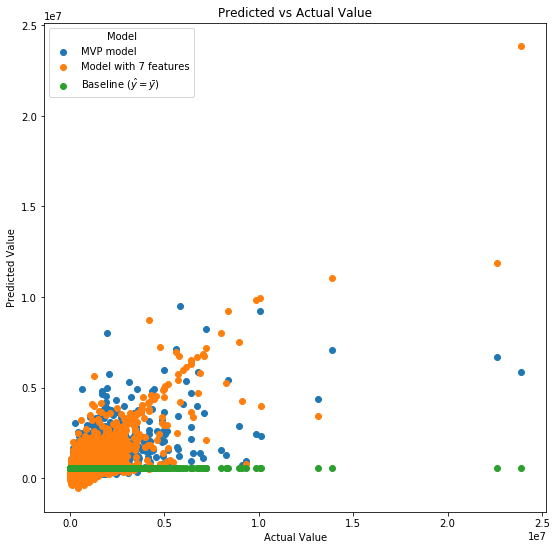

In [26]:
plt.figure(figsize=(9, 9))

plt.scatter(predictions.actual, predictions.MVP, label='MVP model', marker='o')
plt.scatter(predictions.actual, predictions.rfe7, label='Model with 7 features', marker='o')
plt.scatter(predictions.actual, predictions.baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')

plt.legend(title='Model')
plt.ylabel('Predicted Value')
plt.xlabel('Actual Value')
plt.title('Predicted vs Actual Value')

9. Report R2 and coefficients

In [27]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X_rfe7)
lm_rfe7 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)
r2_lm = lm_rfe7.score(X_poly, y)

print(f'{r2_lm:.2%} of the variance in the value of a home can be explained by 7 features.')

67.20% of the variance in the value of a home can be explained by 7 features.


In [28]:
rfe = RFE(lm_rfe7, 7)
X_rfe = rfe.fit_transform(X_rfe7,y)  
mask = rfe.support_
rfe_features = X_rfe7.columns[mask]

In [37]:
output = "{} = {:.4f} + {:.2f} * {} + {:.3f} * {}".format(
    y.columns[0],
    lm_rfe7.intercept_[0],
    lm_rfe7.coef_[0][0],
    rfe_features[0],
    lm_rfe7.coef_[0][1],
    rfe_features[1],
)
print(output)

value = 11193292.8629 + -3366.81 * sq_feet_proxy6 + 3500479.916 * size_ratio


10. Apply this model to the test set and report RMSE & R2

In [38]:
X = train[['sq_feet_proxy6', 'size_ratio', 'baths', 'beds', 'roomcnt', 
            'is_extra', 'all_rooms']]
y = train[['value']]

poly = PolynomialFeatures(degree=7, include_bias=False, interaction_only=True)
poly.fit(X)
X_poly = poly.fit_transform(X)
lm = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)

In [39]:
X_test = test[['sq_feet_proxy6', 'size_ratio', 'baths', 'beds', 'roomcnt', 
            'is_extra', 'all_rooms']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.value
RMSE = model.RMSE(test_actual, test_predictions)
RMSE

747099.022613376

11. Compare to MVP model

In [40]:
X = train[['baths', 'beds', 'home_sf']]
y = train[['value']]

poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
poly.fit(X)
X_poly = poly.fit_transform(X)
lm = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_poly, y)

In [41]:
X_test = test[['baths', 'beds', 'home_sf']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.value
RMSE = model.RMSE(test_actual, test_predictions)
RMSE

532684.7298274062

In [42]:
y_test = test[['value']]
lm_test = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False).fit(X_test_poly, y_test)
r2 = lm_test.score(X_test_poly, y_test)

print(f'{r2:.2%} of the variance in the value of a home can be explained by 3 features.')

58.21% of the variance in the value of a home can be explained by 3 features.


In [43]:
X_test.columns[0]

'baths'

In [44]:
output = "{} = {:.4f} + {:.2f} * {} + {:.3f} * {} + {:.3f} * {}".format(
    y_test.columns[0],
    lm_test.intercept_[0],
    lm_test.coef_[0][0],
    X_test.columns[0],
    lm_test.coef_[0][1],
    X_test.columns[1],
    lm_test.coef_[0][2],
    X_test.columns[2],
)
print(output)

value = -433573.7592 + 528165.58 * baths + 25661.808 * beds + 493.608 * home_sf


So, after all that work, the model with 7 features was overfit. The MVP model significantly outperformed the model with 7 features!